https://justincollier.com/life-hacks/how-to-win-rock-paper-scissors/:

**What to throw first:**
- People tend to throw rock first, followed by paper followed by scissor. So best strategy is to throw paper.

**What to throw after a tie:**
- After a rock-rock tie: Throw rock. Scissors and rock are most common throws. 
- After a paper-paper tie: Throw scissors. Rock is the least likely throw after a paper-paper tie.
- After a scissor-scissor tie: Throw paper. Scissor is the least likely throw after a scissor-scissor tie. 

**Next throw after a win:**
- Rock --> Paper
- Paper --> Scissor
- Scissor --> Paper

**Next throw after a lost:**
- Rock --> Scissor
- Scissor --> Paper
- Paper --> Rock

In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel('data/Rock_Paper_Scissors_Raw.xlsx')

In [2]:
# throws: `1` = rock, `2` = paper, `3` = scissors, `0` = no input
df.head()

,game_id,game_round_id,player_one_throw,player_two_throw
0,1,1,1,1
1,1,1,2,3
2,1,2,3,2
3,1,3,1,1
4,1,3,1,2


In [3]:
df.shape

(455180, 4)

In [4]:
df[['player_one_throw', 'player_two_throw']] = df[['player_one_throw', 'player_two_throw']].replace({1: 'rock', 2: 'paper', 3: 'scissors', 0: 'no_input'})

In [5]:
df.drop(df[df['player_two_throw'] == 'no_input'].index, axis=0, inplace=True)

In [6]:
df.drop(df[df['player_one_throw'] == 'no_input'].index, axis=0, inplace=True)

In [7]:
df['complete_play'] = df['player_one_throw'] + '_' + df['player_two_throw']

In [8]:
df.complete_play.value_counts()

rock_rock            50228
paper_rock           47516
rock_paper           46968
paper_paper          46361
scissors_rock        46008
rock_scissors        44071
scissors_paper       43477
paper_scissors       42423
scissors_scissors    42390
Name: complete_play, dtype: int64

In [9]:
df['winner'] = 'NA'

for i, row in df.iterrows():
    if row['complete_play'] in ['rock_rock', 'paper_paper', 'scissors_scissors']:
        df.at[i, 'winner'] = 'tie'

In [10]:
# player 1 wins: paper_rock, rock_scissors, rock_scissors
# player 2 wins: rock_paper, scissors_rock, paper_scissors
for i, row in df.iterrows():
    if row['complete_play'] in ['paper_rock', 'rock_scissors', 'scissors_paper']:
        df.at[i, 'winner'] = 'bot'
    elif row['complete_play'] in ['rock_paper', 'scissors_rock', 'paper_scissors']:
        df.at[i, 'winner'] = 'human'

In [11]:
df.winner.value_counts()

tie      138979
human    135399
bot      135064
Name: winner, dtype: int64

In [12]:
df['game_actual_round'] = df.groupby('game_id').cumcount() + 1

In [13]:
df['previous_player_two_throw'] = df['player_two_throw'].shift(1)
df['pprevious_player_two_throw'] = df['player_two_throw'].shift(2)

In [14]:
df['previous_winner'] = df['winner'].shift(1)

In [15]:
df['previous_complete_play'] = df['complete_play'].shift(1)

In [16]:
df.head()

,game_id,game_round_id,player_one_throw,player_two_throw,complete_play,winner,game_actual_round,previous_player_two_throw,pprevious_player_two_throw,previous_winner,previous_complete_play
0,1,1,rock,rock,rock_rock,tie,1,NaN,NaN,NaN,NaN
1,1,1,paper,scissors,paper_scissors,human,2,rock,NaN,tie,rock_rock
2,1,2,scissors,paper,scissors_paper,bot,3,scissors,rock,human,paper_scissors
3,1,3,rock,rock,rock_rock,tie,4,paper,scissors,bot,scissors_paper
4,1,3,rock,paper,rock_paper,human,5,rock,paper,tie,rock_rock


In [17]:
for i, row in df[df['game_actual_round'] == 2].iterrows():
    df.at[i, 'pprevious_player_two_throw'] = 'second_game'

In [18]:
df = df.drop(df[df['game_actual_round'] == 1].index, axis=0)

In [40]:
df = df.drop(df[df['game_actual_round'] == 2].index, axis=0)

In [41]:
df.shape

(267347, 11)

# Model

In [42]:
from sklearn_pandas import DataFrameMapper
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [43]:
df.columns

Index(['game_id', 'game_round_id', 'player_one_throw', 'player_two_throw',
       'complete_play', 'winner', 'game_actual_round',
       'previous_player_two_throw', 'pprevious_player_two_throw',
       'previous_winner', 'previous_complete_play'],
      dtype='object')

In [44]:
drop = ['game_id', 'game_round_id', 'player_one_throw', 'complete_play', 'winner', 'game_actual_round']

In [45]:
df_f = df.drop(drop, axis=1)
df_f.head(10)

,player_two_throw,previous_player_two_throw,pprevious_player_two_throw,previous_winner,previous_complete_play
2,paper,scissors,rock,human,paper_scissors
3,rock,paper,scissors,bot,scissors_paper
4,paper,rock,paper,tie,rock_rock
5,scissors,paper,rock,human,rock_paper
9,scissors,rock,rock,bot,paper_rock
12,paper,paper,scissors,bot,scissors_paper
13,rock,paper,paper,tie,paper_paper
14,scissors,rock,paper,tie,rock_rock
15,scissors,scissors,rock,tie,scissors_scissors
16,paper,scissors,scissors,tie,scissors_scissors


In [46]:
df_f.columns = df_f.columns.str.replace('player_one', 'bot')
df_f.columns = df_f.columns.str.replace('player_two', 'human')

In [47]:
df_f.dtypes

human_throw               object
previous_human_throw      object
pprevious_human_throw     object
previous_winner           object
previous_complete_play    object
dtype: object

In [48]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn_pandas import CategoricalImputer

mapper = DataFrameMapper([
    ('previous_human_throw', LabelEncoder()),
    ('pprevious_human_throw', LabelEncoder()),
    ('previous_winner', LabelEncoder()),
    ('previous_complete_play', LabelBinarizer())
], df_out=True)

lb = LabelEncoder()
y = lb.fit_transform(df_f['human_throw'])

In [49]:
from sklearn.model_selection import train_test_split

df_t = mapper.fit_transform(df_f)
df_t.head()

,previous_human_throw,pprevious_human_throw,previous_winner,previous_complete_play_paper_paper,previous_complete_play_paper_rock,previous_complete_play_paper_scissors,previous_complete_play_rock_paper,previous_complete_play_rock_rock,previous_complete_play_rock_scissors,previous_complete_play_scissors_paper,previous_complete_play_scissors_rock,previous_complete_play_scissors_scissors
2,2,1,1,0,0,1,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,1,0,0
4,1,0,2,0,0,0,0,1,0,0,0,0
5,0,1,1,0,0,0,1,0,0,0,0,0
9,1,1,0,0,1,0,0,0,0,0,0,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_t, y, random_state=42, test_size=0.2)

In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.37445296427903496

In [52]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.38915279596035157

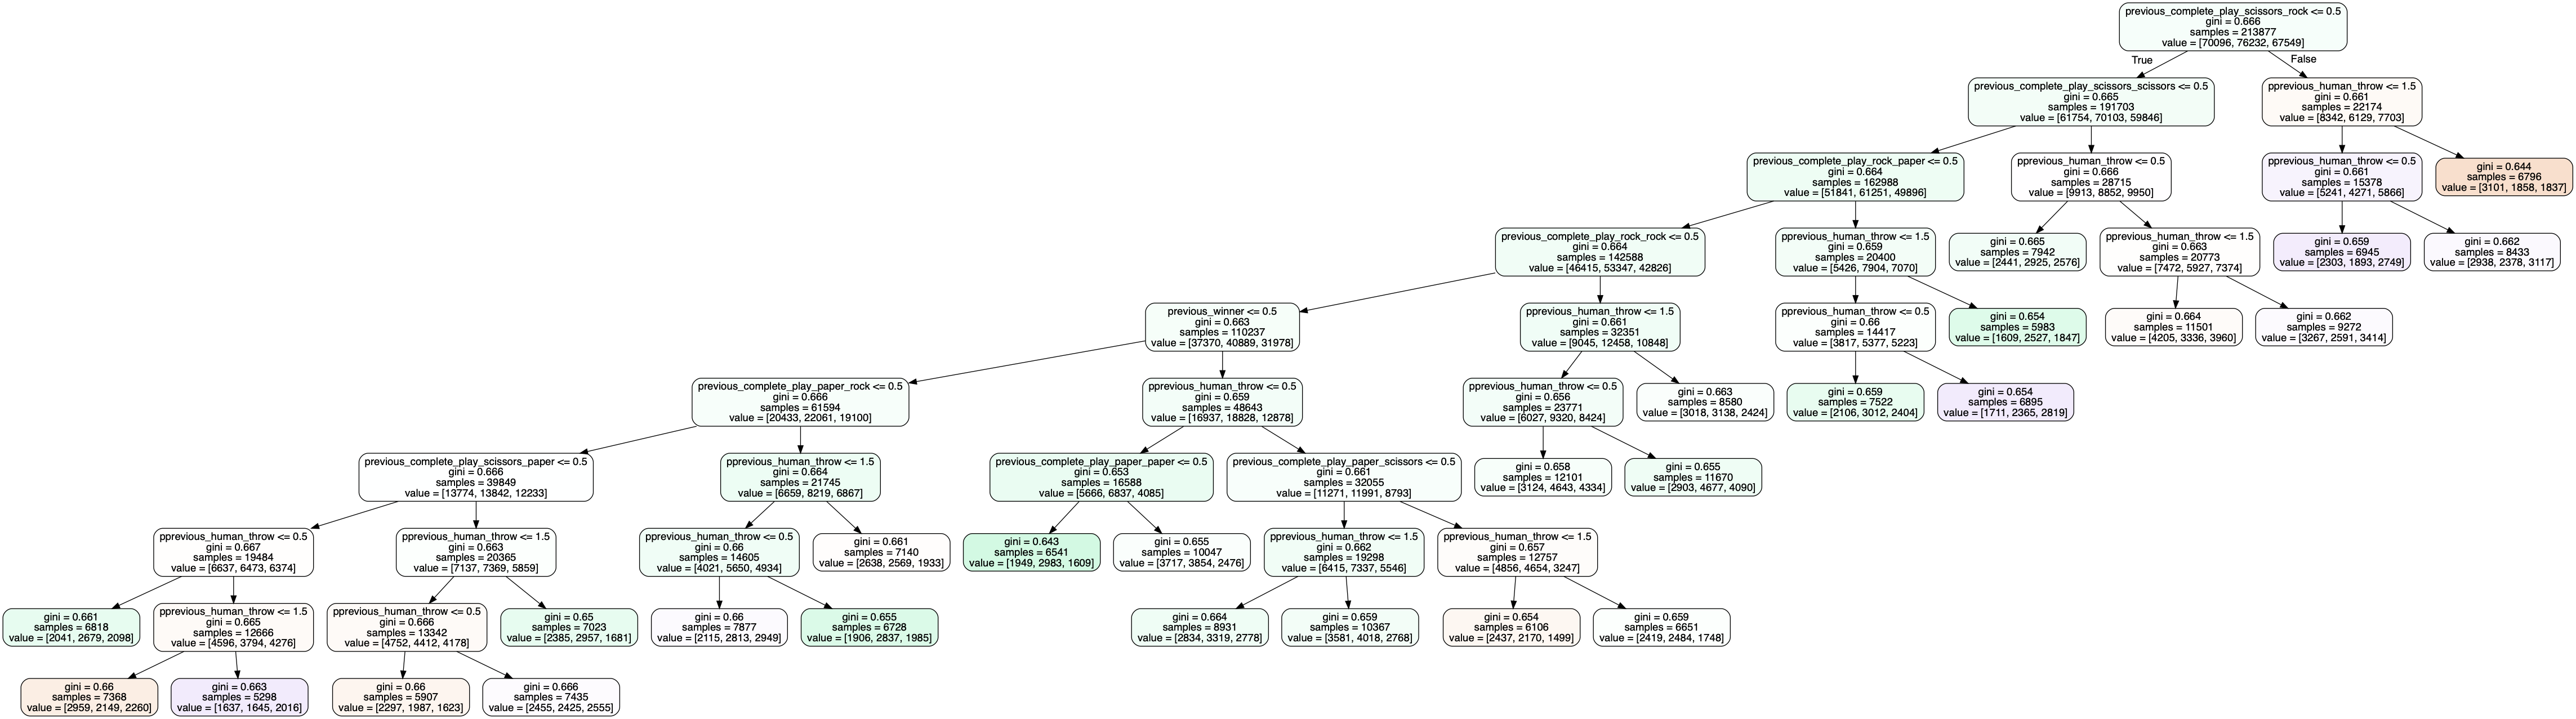

In [53]:
from IPython.display import Image  
import pydotplus
from sklearn import tree

dot_data = tree.export_graphviz(
    dt, 
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=X_train.columns)

graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('original_tree.png')
Image(graph.create_png())

In [54]:
bag = BaggingClassifier()
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.38915279596035157

In [55]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.38915279596035157

In [56]:
import catboost as cb
from catboost import CatBoostClassifier, cv, Pool
import shap

cbmodel = CatBoostClassifier(
    iterations=250,
    learning_rate=0.2,
    early_stopping_rounds = 30,
    loss_function = 'MultiClass', 
    custom_metric='Accuracy',
    use_best_model=True,
    verbose=5
)

cbmodel.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: -1.0947710	test: -1.0949704	best: -1.0949704 (0)	total: 230ms	remaining: 57.2s
5:	learn: -1.0882020	test: -1.0889315	best: -1.0889315 (5)	total: 1.11s	remaining: 45.4s
10:	learn: -1.0867484	test: -1.0877395	best: -1.0877395 (10)	total: 1.94s	remaining: 42.1s
15:	learn: -1.0863704	test: -1.0874697	best: -1.0874697 (15)	total: 2.5s	remaining: 36.6s
20:	learn: -1.0861851	test: -1.0874440	best: -1.0874360 (18)	total: 3.11s	remaining: 33.9s
25:	learn: -1.0861571	test: -1.0874704	best: -1.0874360 (18)	total: 3.66s	remaining: 31.5s
30:	learn: -1.0861401	test: -1.0874911	best: -1.0874360 (18)	total: 4.23s	remaining: 29.9s
35:	learn: -1.0861294	test: -1.0875088	best: -1.0874360 (18)	total: 4.89s	remaining: 29.1s
40:	learn: -1.0861256	test: -1.0875142	best: -1.0874360 (18)	total: 5.49s	remaining: 28s
45:	learn: -1.0861237	test: -1.0875186	best: -1.0874360 (18)	total: 6.12s	remaining: 27.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = -1.087436046
bestIteration = 18

In [40]:
import xgboost as xgb
from xgboost import plot_tree, XGBClassifier, plot_importance

xg = xgb.XGBClassifier(
    n_estimators = 50,
    num_class = 3, 
    objective = 'reg:logistic', 
    eval_set='Accuracy', 
    learning_rate=0.1, 
    early_stopping_rounds=10,           
    max_depth=3, 
    silent=False) 

xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, eval_set='Accuracy',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, num_class=3, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [41]:
xg.score(X_test, y_test)

0.3786833396426871

In [57]:
import pickle
from sklearn.pipeline import Pipeline
pipe = Pipeline([("mapper", mapper), ("model", rf)])

# serializing model to a file
pickle.dump(pipe, open("model.pkl", "wb"))

In [58]:
X_train.to_csv('train_data.csv', index=False)

In [59]:
new_data = pd.DataFrame({'previous_human_throw': ['rock'],
                         'pprevious_human_throw': ['paper'],
                         'previous_winner': ['tie'],
                         'previous_complete_play': ['paper_scissors']})

In [60]:
prediction = pipe.predict_proba(new_data)
prediction

array([[0.29634899, 0.43132567, 0.27232534]])

In [61]:
lb.inverse_transform([0, 1, 2])

array(['paper', 'rock', 'scissors'], dtype=object)